In [1]:
from abc import ABC, abstractmethod
from tensorflow.keras import Sequential
import numpy as np
import random
import pickle
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

2023-03-12 19:37:27.438954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 19:37:27.926291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-12 19:37:27.926362: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-12 19:37:29.950177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class BaseModel(ABC):
    @abstractmethod
    def __init__(self, discount_factor: float, epsilon: float, e_min: int, e_max: int):
        """
        self.qNetwork and self.qTargetNetwork need to be installed.

        :param discount_factor: It’s used to balance immediate and future reward.
        Typically this value can range anywhere from 0.8 to 0.99.

        :param epsilon: the probability of choosing to explore action.
        :param e_min: Minimum amount of experience to start training.
        :param e_max: Maximum amount of experience.
        """
        pass

    @abstractmethod
    def observe(self, state, action_space: list = None):
        """
        Observe state from environment and return a action

        :param state: Current situation returned by the environment.
        :param action_space: All the possible moves that the agent can take.
        :return: Action that have the max value from q table value.

        Note: If actionSpace is None then all action are possible
        """
        pass

    @abstractmethod
    def observe_on_training(self, state, action_space: list = None) -> int:
        """
        Observe state from environment and return a action by epsilon greedy policy.
        The state and action will be stored in the memory buffer to be used for Experience Replay

        :param state: Current situation returned by the environment.
        :param action_space: All the possible moves that the agent can take.
        :return: Action that have the max value from q table value.
        Note: If actionSpace is None then all action are possible
        """
        pass

    @abstractmethod
    def take_reward(self, reward, next_state, done):
        """
        After used observeOnTraining method, environment will return reward, nextState and done information
        we will use this method to put that information into the Experience Replay

        :param reward: immediate reward returned by the environment
        :param next_state: Next situation returned by the environment.
        :param done: describes whether the environment situation has terminated or not
        :return: None
        """
        pass

    @abstractmethod
    def train_network(self, sample_size: int, batch_size: int, epochs: int, verbose: int = 2, cer_mode: bool = False):
        """
        :param sample_size: number of samples taken from Experience Replay.
        :param batch_size: Integer or `None`. Number of samples per gradient update. If unspecified,
        `batch_size` will default to 32. Do not specify the `batch_size` if your data is in the form of datasets,
        generators, or `keras.utils.Sequence` instances (since they generate batches).
        :param epochs: Integer. Number of epochs to train the model.
        An epoch is an iteration over the entire `x` and `y` data provided.
        Note that in conjunction with `initial_epoch`, `epochs` is to be understood as "final epoch".
        The model is not trained for a number of iterations given by `epochs`, but merely until the epoch of index
        `epochs` is reached.
        :param verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        Note that the progress bar is not particularly useful when logged to a file, so verbose=2 is recommended
        when not running interactively (eg, in a production environment).
        :param cer_mode: Turn on or off cer (Combined Experience Replay). Default is False.
        :return: None
        """
        pass

    @abstractmethod
    def update_target_network(self):
        """
        Update Q target Network by weight of Q network
        :return: None
        """
        pass


In [3]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def perform(self, q_value, action_space: list = None):
        prob = np.random.sample()  # get probability of taking random action
        if prob <= self.epsilon:  # take random action
            if action_space is None:  # all action are available
                return np.random.randint(len(q_value))
            return random.choice(action_space)
        else:  # take greedy action
            if action_space is None:
                return np.argmax(q_value)
            return max([[q_value[a], a] for a in action_space], key=lambda x: x[0])[1]

    def decay(self, decay_value, lower_bound):
        """
        Adjust the epsilon value by the formula: epsilon = max(decayValue * epsilon, lowerBound).
        :param decay_value: Value ratio adjustment (0, 1).
        :param lower_bound: Minimum epsilon value.
        :return: None
        """
        self.epsilon = max(self.epsilon * decay_value, lower_bound)


In [4]:
class ExperienceReplay:
    def __init__(self, e_max: int):
        if e_max <= 0:
            raise ValueError('Invalid value for memory size')
        self.e_max = e_max
        self.memory = list()
        self.index = 0

    def add_experience(self, sample: list):
        if len(sample) != 5:
            raise Exception('Invalid sample')
        if len(self.memory) < self.e_max:
            self.memory.append(sample)
        else:
            self.memory[self.index] = sample
        self.index = (self.index + 1) % self.e_max

    def sample_experience(self, sample_size: int, cer_mode: bool):
        samples = random.sample(self.memory, sample_size)
        if cer_mode:
            samples[-1] = self.memory[self.index - 1]
        # state_samples, action_samples, reward_samples, next_state_samples, done_samples
        s_batch, a_batch, r_batch, ns_batch, done_batch = map(np.array, zip(*samples))
        return s_batch, a_batch, r_batch, ns_batch, done_batch

    def get_size(self):
        return len(self.memory)


In [5]:
class DQN(BaseModel):
    def __init__(self, discount_factor: float, epsilon: float, e_min: int, e_max: int):
        super().__init__(discount_factor, epsilon, e_min, e_max)
        self.gamma = discount_factor
        self.epsilon_greedy = EpsilonGreedy(epsilon)
        self.e_min = e_min
        self.exp_replay = ExperienceReplay(e_max)
        self.target_network = Sequential()
        self.training_network = Sequential()
        self.cache = list()

    def observe(self, state, action_space: list = None):
        q_value = self.training_network.predict(np.array([state])).ravel()
        if action_space is not None:
            return max([[q_value[a], a] for a in action_space], key=lambda x: x[0])[1]
        return np.argmax(q_value)

    def observe_on_training(self, state, action_space: list = None) -> int:
        q_value = self.training_network.predict(np.array([state])).ravel()
        action = self.epsilon_greedy.perform(q_value, action_space)
        self.cache.extend([state, action])
        return action

    def take_reward(self, reward, next_state, done):
        self.cache.extend([reward, next_state, done])
        self.exp_replay.add_experience(self.cache.copy())
        self.cache.clear()

    def train_network(self, sample_size: int, batch_size: int, epochs: int, verbose: int = 2, cer_mode: bool = False):
        if self.exp_replay.get_size() >= self.e_min:
            # state_samples, action_samples, reward_samples, next_state_samples, done_samples
            s_batch, a_batch, r_batch, ns_batch, done_batch = self.exp_replay.sample_experience(sample_size, cer_mode)
            states, q_values = self.replay(s_batch, a_batch, r_batch, ns_batch, done_batch)
            history = self.training_network.fit(states, q_values, epochs=epochs, batch_size=batch_size, verbose=verbose)
            return history.history['loss']

    def replay(self, states, actions, rewards, next_states, terminals):
        q_values = self.target_network.predict(np.array(states))  # get q value at state t by target network
        nq_values = self.target_network.predict(np.array(next_states))  # get q value at state t+1 by target network
        for i in range(len(states)):
            a = actions[i]
            done = terminals[i]
            r = rewards[i]
            if done:
                q_values[i][a] = r
            else:
                q_values[i][a] = r + self.gamma * np.max(nq_values[i])
        return states, q_values

    def update_target_network(self):
        self.target_network.set_weights(self.training_network.get_weights())


In [6]:
from movement import *
from Reward import *
from cmath import inf

pawnPromotions = ['r', 'n', 'q', 'b']


def board(state):
    """
    Board: Bàn cờ hiện tại
    islower: lượt của quân viết thường (True) hay quân viết hoa (False)
    return: giá trị của bàn cờ đối với quân viết thường
    """
    board = [[0]*8 for _ in range(8)]
    for y in range(8):
        for x in range(8):
            c = state[y][x]
            if c == 0:
                board[y][x] = ' '
            elif abs(c) == 1:
                board[y][x] = 'p' if c > 0 else 'P'
            elif abs(c) == 3:
                board[y][x] = 'n' if c > 0 else 'N'
            elif abs(c) == 3.3:
                board[y][x] = 'b' if c > 0 else 'B'
            elif abs(c) == 5:
                board[y][x] = 'r1' if c > 0 else 'R1'
            elif abs(c) == 5.1:
                board[y][x] = 'r2' if c > 0 else 'R2'
            elif abs(c) == 20:
                board[y][x] = 'q' if c > 0 else 'Q'
            elif abs(c) == 1000:
                board[y][x] = 'k' if c > 0 else 'K'
            else:
                print('Unknown piece:', c)
    return board


class Chess_Env:
    def __init__(self):
        self.board = [["r1", "n", "b", "q", "k", "b", "n", "r2"],
                      ["p", "p", "p", "p", "p", "p", "p", "p"],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      ["P", "P", "P", "P", "P", "P", "P", "P"],
                      ["R1", "N", "B", "Q", "K", "B", "N", "R2"]]
        self.isLower = True
        self.isMoved = {'k': False, 'K': False, 'r1': False,
                        'R1': False, 'r2': False, 'R2': False}

    def reset(self, isLowerFirst):
        self.board = [["r1", "n", "b", "q", "k", "b", "n", "r2"],
                      ["p", "p", "p", "p", "p", "p", "p", "p"],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      [" ", " ", " ", " ", " ", " ", " ", " "],
                      ["P", "P", "P", "P", "P", "P", "P", "P"],
                      ["R1", "N", "B", "Q", "K", "B", "N", "R2"]]

        self.isMoved = {'k': False, 'K': False, 'r1': False,
                        'R1': False, 'r2': False, 'R2': False}
        self.isLower = True
        self.player_mark = 1 if isLowerFirst else 0
        if isLowerFirst:
            self.env_act()
        return self.state.copy()

    def check_win(self):
        U, L = False, False
        for _ in self.board:
            U = U or ('K' in _)
            L = L or ('k' in _)

        if U and L:
            return 0, False
        elif U:
            return 1000, True
        return -1000, True

    def env_act(self):
        action = random.choice(
            CanGoList(self.board, self.isLower, self.isMoved))
        row, col, newRow, newCol = action
        if self.isLower and 'p' in self.board[row][col] and row == 6:
            pawnPromotion(self.board, row, col, newRow, newCol,
                          random.choice(pawnPromotions))
        elif not self.isLower and 'P' in self.board[row][col] and row == 1:
            pawnPromotion(self.board, row, col, newRow, newCol,
                          random.choice(pawnPromotions).upper())
        else:
            makeMove(self.board, row, col, newRow, newCol, self.isMoved)

        self.isLower = not self.isLower
        reward, done = self.check_win()
        if done:
            return reward, done
        else:
            reward = Reward(chessBoard, self.isLower)
            return reward, done

    def step(self, action, isMoved={}, pro=None):
        row, col, newRow, newCol = action
        curPiece = pro or self.board[row][col]
        self.board[newRow][newCol] = curPiece
        self.board[row][col] = ' '

        if curPiece in 'kKR1r1R2r2':
            isMoved[curPiece] = True

        #  Quân trắng
        if curPiece == 'K' and col - newCol == -2:
            #  Di chuyển quân xe phải để nhập thành
            row1, col1 = 7, 7
            newRow, newCol = 7, 5
            self.board[newRow][newCol] = self.board[row1][col1]
            self.board[row1][col1] = ' '

        if curPiece == 'K' and col - newCol == 2:
            #  Di chuyển quân xe trái để nhập thành
            row1, col1 = 7, 0
            newRow, newCol = 7, 3
            self.board[newRow][newCol] = self.board[row1][col1]
            self.board[row1][col1] = ' '

        #  Quân trắng
        if curPiece == 'k' and col - newCol == -2:
            #  Di chuyển quân xe phải để nhập thành
            row1, col1 = 0, 7
            newRow, newCol = 0, 2
            self.board[newRow][newCol] = self.board[row1][col1]
            self.board[row1][col1] = ' '

        if curPiece == 'k' and col - newCol == 2:
            #  Di chuyển quân xe trái để nhập thành
            row1, col1 = 0, 0
            newRow, newCol = 0, 3
            self.board[newRow][newCol] = self.board[row1][col1]
            self.board[row1][col1] = ' '

        reward, done = self.check_win()       
        self.isLower = not self.isLower

        if done:
            return self.state.copy(), reward, done, None
        else:
            reward = Reward(self.board, self.isLower)
            return self.state.copy(), reward, done, None

    @property
    def state(self):
        curState = [[0]*8 for _ in range(8)]
        for y in range(8):
            for x in range(8):
                c = self.board[y][x]
                if c == ' ':
                    continue
                if 'p' in c.lower():
                    curState[y][x] = 1 if c.islower() else -1
                elif 'n' in c.lower():
                    curState[y][x] = 3 if c.islower() else -3
                elif 'b' in c.lower():
                    curState[y][x] = 3.3 if c.islower() else -3.3
                elif 'r1' in c.lower():
                    curState[y][x] = 5 if c.islower() else -5
                elif 'r2' in c.lower():
                    curState[y][x] = 5.1 if c.islower() else -5.1
                elif 'q' in c.lower():
                    curState[y][x] = 20 if c.islower() else -20
                elif 'k' in c.lower():
                    curState[y][x] = 1000 if c.islower() else -1000
                else:
                    print('Unknown piece:', c)
        return curState


In [7]:
env = Chess_Env()
agent = DQN(0.7, 1, 4096, 1048576)
op1 = optimizers.RMSprop(learning_rate=0.00025)
agent.training_network.add(Dense(128, activation='relu', input_shape=(8,8,)))
agent.training_network.add(Dense(128, activation='relu'))
agent.training_network.add(Dense(64, activation='linear'))
agent.training_network.compile(optimizer=op1, loss=losses.mean_squared_error)

op2 = optimizers.RMSprop(learning_rate=0.00025)
agent.target_network.add(Dense(128, activation='relu', input_shape=(8,8,)))
agent.target_network.add(Dense(128, activation='relu'))
agent.target_network.add(Dense(64, activation='linear'))
agent.target_network.compile(optimizer=op2, loss=losses.mean_squared_error)
reward_records = list()
loss_records = list()
count = 0
tau = 100
record = 0

2023-03-12 19:37:35.140164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 19:37:35.140196: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 19:37:35.140224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nhamcotdo): /proc/driver/nvidia/version does not exist
2023-03-12 19:37:35.140515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
if __name__ == '__main__':
    for ep in range(100):
        state = env.reset(isLowerFirst=env.isLower)
        done = False
        # print(ep, '------------------', 'current epsilon: ', agent.epsilon_greedy.epsilon)
        while not done:
            action = agent.observe_on_training(state,  CanGoList(board(state), isLower=env.isLower))
            state, reward, done, _ = env.step(action, env.isMoved)
            # print(state, done)
            record += reward
            print(ep, '-----------------------------------', reward)
            agent.take_reward(reward, state, done)
            hist = agent.train_network(64 ,64, 1, 2, cer_mode=True)
            loss_records.append(hist)
            count += 1
            if count % tau == 0:
                agent.update_target_network()
        reward_records.append(record)
        agent.epsilon_greedy.decay(0.99999, 0.1)

1/1 [==============================] - 0s 74ms/step
0 ----------------------------------- -3
2/2 [==============================] - 0s 7ms/step
1/1 - 0s - loss: 12011.5254 - 19ms/epoch - 19ms/step
1/1 [==============================] - 0s 78ms/step
0 ----------------------------------- -52
2/2 [==============================] - 0s 8ms/step
1/1 - 0s - loss: 12809.0527 - 24ms/epoch - 24ms/step
1/1 [==============================] - 0s 63ms/step
0 ----------------------------------- -3
2/2 [==============================] - 0s 6ms/step
1/1 - 0s - loss: 18038.4434 - 45ms/epoch - 45ms/step
1/1 [==============================] - 0s 62ms/step
0 ----------------------------------- -102
2/2 [==============================] - 0s 5ms/step
1/1 - 0s - loss: 6948.0913 - 19ms/epoch - 19ms/step
1/1 [==============================] - 0s 57ms/step
0 ----------------------------------- -3
2/2 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 62330.1172 - 11ms/epoch - 11ms/step
1/1 [=======

KeyboardInterrupt: 

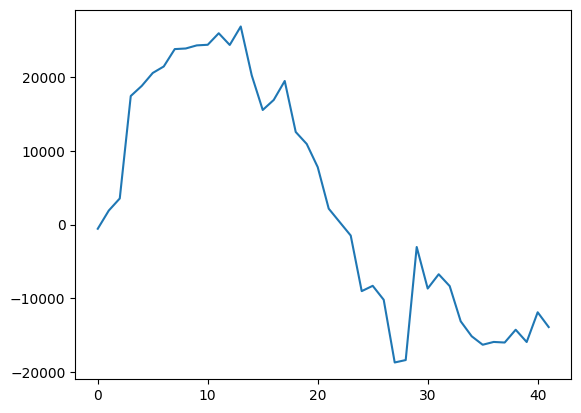

In [15]:
plt.plot(range(len(reward_records)),  reward_records)
plt.show()

In [12]:
with open('chess100.pkl', 'wb') as f:
    pickle.dump(agent.training_network.get_weights(), f,pickle.HIGHEST_PROTOCOL)